# Setup

In [19]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]  # adjust if notebook is nested
sys.path.append(str(PROJECT_ROOT))

print("Added to PYTHONPATH:", PROJECT_ROOT)

Added to PYTHONPATH: c:\Users\yfess\Desktop\timeseries-thesis


In [20]:
from dotenv import load_dotenv
import os

env_file = PROJECT_ROOT / ".env.benchmark_db"

print( env_file.exists())

load_dotenv(env_file)

print("Loaded env file:", env_file)
print("DB PORT:", os.getenv("POSTGRES_PORT"))

True
Loaded env file: c:\Users\yfess\Desktop\timeseries-thesis\.env.benchmark_db
DB PORT: 5467


In [21]:
# from src.databases.benchmark_db.models import Benchmark 
from src.common.config import load_config
from src.common.logger import get_logger
from src.databases.benchmark_db.config import get_postgres_config
from src.databases.benchmark_db.benchmark_db import BenchmarkDB

In [22]:
bmdb_config_file_path = PROJECT_ROOT / "configs/config-benchmark_db.yml"
bmdb_config_file_path

WindowsPath('c:/Users/yfess/Desktop/timeseries-thesis/configs/config-benchmark_db.yml')

In [23]:
bmdb_config = load_config(bmdb_config_file_path)
bmdb_config

{'postgres': {'POSTGRES_USER': 'postgres',
  'POSTGRES_PASSWORD': 'password123',
  'POSTGRES_DATABASE': 'benchmark_db',
  'POSTGRES_HOST': 'localhost',
  'POSTGRES_PORT': '5467',
  'POSTGRES_SCHEMA': 'public'},
 'general': {'log_file': './logs/benchmark_db_forwarder.log'}}

In [24]:

logger = get_logger("benchmark_db", bmdb_config["general"]["log_file"])

benchmark_db_config = get_postgres_config(bmdb_config["postgres"])
bm_db = BenchmarkDB(benchmark_db_config, logger)
print(bm_db.connect())

True


In [25]:
import inspect
from src.databases.benchmark_db.models import Benchmark

print("Benchmark model file:", inspect.getfile(Benchmark))
print("Benchmark columns:", Benchmark.__table__.columns.keys())

Benchmark model file: c:\Users\yfess\Desktop\timeseries-thesis\src\databases\benchmark_db\models.py
Benchmark columns: ['id', 'benchmark_name', 'database_name', 'dataset_name', 'total_points', 'total_seconds', 'throughput_points_per_sec', 'success', 'created_at']


In [26]:
benchmark_ALL  = bm_db.get_all()

In [27]:
one_bm = benchmark_ALL[0]
print(one_bm.created_at)

2026-02-04 17:20:06.356856+00:00


In [28]:
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
df = pd.DataFrame(
    [
        {
            "id": b.id,
            "benchmark_name": b.benchmark_name,
            "database_name": b.database_name,
            "dataset_name": b.dataset_name,
            "total_points": b.total_points,
            "total_seconds": b.total_seconds,
            "throughput_points_per_sec": b.throughput_points_per_sec,
            "success": b.success,
            "created_at": b.created_at,
        }
        for b in benchmark_ALL
    ]
)

df.head(1)

,id,benchmark_name,database_name,dataset_name,total_points,total_seconds,throughput_points_per_sec,success,created_at
0,10330,ingestion.insert_many.fixed_batch,mongodb,data_observations_1_20250114_20250114.json,1,0.00276,362.253215,True,2026-02-04 17:20:06.356856+00:00


In [30]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   id                         40000 non-null  int64              
 1   benchmark_name             40000 non-null  str                
 2   database_name              40000 non-null  str                
 3   dataset_name               40000 non-null  str                
 4   total_points               40000 non-null  int64              
 5   total_seconds              40000 non-null  float64            
 6   throughput_points_per_sec  40000 non-null  float64            
 7   success                    40000 non-null  bool               
 8   created_at                 40000 non-null  datetime64[us, UTC]
dtypes: bool(1), datetime64[us, UTC](1), float64(2), int64(2), str(3)
memory usage: 2.5 MB


### Mean Insert Throughput

In [31]:

df_ok = df[df["success"]].copy()

df_agg = (
    df_ok
    .groupby(["total_points", "database_name"], as_index=False)
    .agg(mean_throughput=("throughput_points_per_sec", "mean"))
)

In [32]:
total_points_list = sorted(df_agg["total_points"].unique())[:4]
total_points_list

[np.int64(1), np.int64(10), np.int64(100), np.int64(1000)]

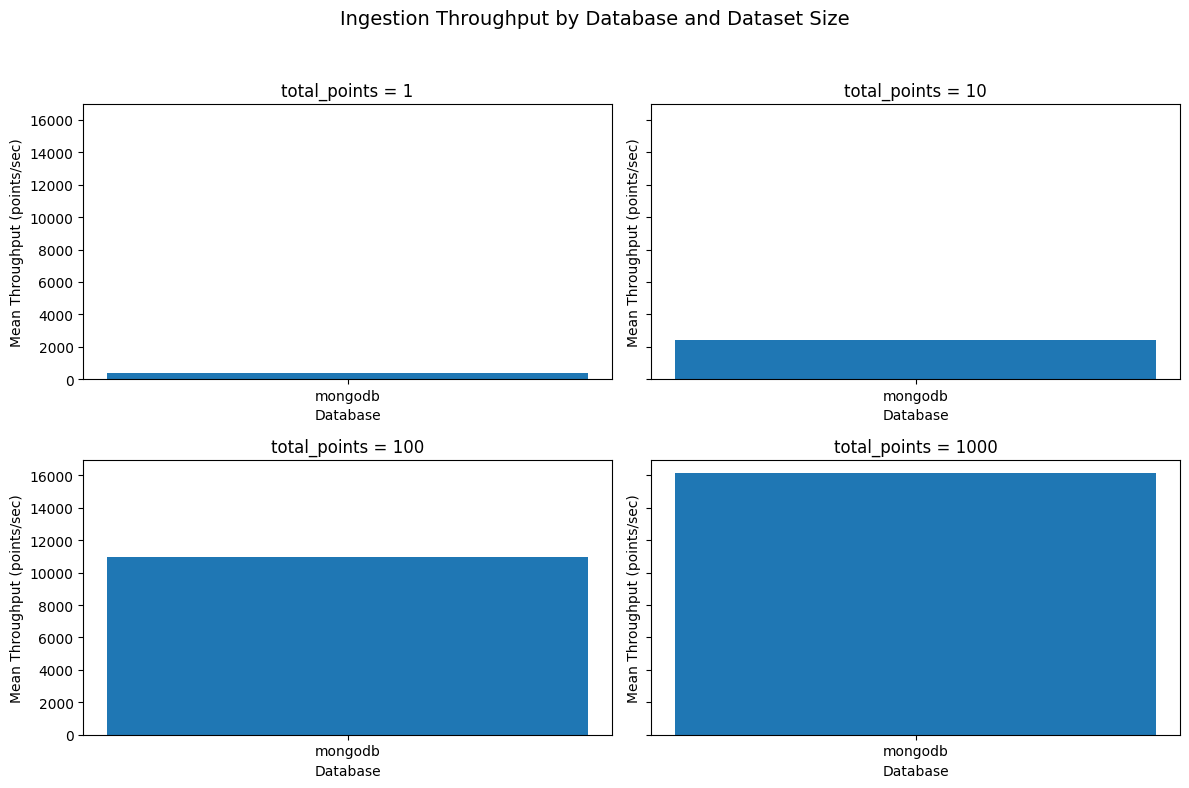

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for ax, tp in zip(axes, total_points_list):
    d = (
        df_agg[df_agg["total_points"] == tp]
        .sort_values("database_name")
    )

    ax.bar(d["database_name"], d["mean_throughput"])
    ax.set_title(f"total_points = {tp}")
    ax.set_xlabel("Database")
    ax.set_ylabel("Mean Throughput (points/sec)")

plt.suptitle("Ingestion Throughput by Database and Dataset Size", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


###  Mean Insert Time

In [34]:
df_ok = df[df["success"]].copy()

df_agg = (
    df_ok
    .groupby(["total_points", "database_name"], as_index=False)
    .agg(mean_insert_time_sec=("total_seconds", "mean"))
)

In [35]:
total_points_list = sorted(df_agg["total_points"].unique())[:4]
total_points_list

[np.int64(1), np.int64(10), np.int64(100), np.int64(1000)]

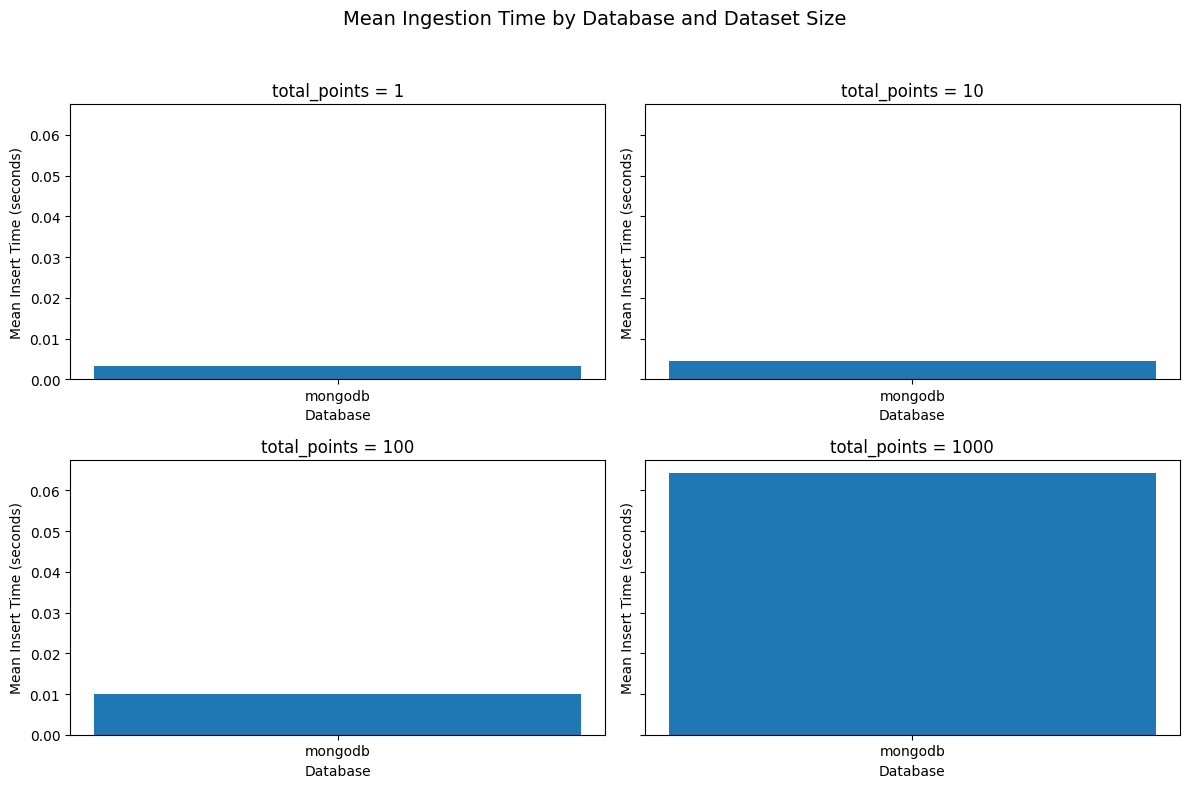

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for ax, tp in zip(axes, total_points_list):
    d = (
        df_agg[df_agg["total_points"] == tp]
        .sort_values("database_name")
    )

    ax.bar(d["database_name"], d["mean_insert_time_sec"])
    ax.set_title(f"total_points = {tp}")
    ax.set_xlabel("Database")
    ax.set_ylabel("Mean Insert Time (seconds)")

plt.suptitle("Mean Ingestion Time by Database and Dataset Size", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
